# Implement hard-margin SVM with QP by cvxopt
Author: Yin-tao Xu | Date: 2018/9/10
## Part0: Introduction
[Hard-Margin SVM](https://en.wikipedia.org/wiki/Support_vector_machine#Hard-margin) can be transformed into a standard [QP problem](https://en.wikipedia.org/wiki/Quadratic_programming). For beginners or researchers focusing on application, it is challenging to implement very detailed numerical optimization method. 

One way is to transmute this question into a more well-studied and basic optimization problem. Rely on magic boxes in cvxopt package, you are able to derive the solution with only one command! 

From my POV, experiencing the process of the modeling of hard-margin SVM is required for machine learning beginners since it could be one of your gates to the theory of machine learning. Simutaneously, it also works very well in most cases.

### 0.1 Prerequisite
1. Get familiar with the basic modeling of the hard-margin SVM.
2. Get familiar with the idea of how to transforming into a QP-Problem
3. Have cvxopt installed. [Install insturction](http://cvxopt.org/install/)

You may be puzzled with these two points. 

Here are two tutorials in English ([Note from standformd CS229](http://cs229.stanford.edu/notes/cs229-notes3.pdf)) 

**Note**: For notes in standford, first 7 pages will provide you with enough background knowledge about SVM(before lagrange duality). It's quite easy to transform the optimization problem into QP standard form if you have basic knowledge of linear algebra. 

and Chinese([author's CSDN blog](https://blog.csdn.net/liubai01/article/details/82017964)).

### 0.2 Self-check, SVM optimization objective function
To help you recall the knowledge of support vector mechine(SVM), here is the formulation of a basic SVM problem.
$$
    \min_{w, b} \frac{1}{2} \textbf{w}^T \textbf{w}
$$
$$
    s.t: \,\, \forall i\in[N]: y_n (\textbf{w}^Tx_n+b) \geqslant 1
$$
Here I omit the introduction of each variable. If you have question, go for two tutorials above for help!

## PartI : Get familiar with cvxopt package

In [1]:
%matplotlib inline
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from utils.visualize_tools import plot_example_1, plot_Xy, plot_classifer
from utils.data_loader import load_in_data
solvers.options["show_progress"] = False

A standard form of Quadratic Programming(QP) at cvxopt document is:
$$
    \text{minimize }\frac{1}{2}x^TPx+q^Tx\\
    Gx \preceq h\\
    Ax=b
$$
cvxopt.solvers.qp(P, q, G, h, A, b) is a helper to solve this question

### Example 1:
Consider the following optimization problem:
$$
    \text{maximize}_x -\frac{1}{2}x^2+3\\
    x\geqslant1.25\\
$$
Solve it by cvxopt package, transcribe this problem into a standard QP problem

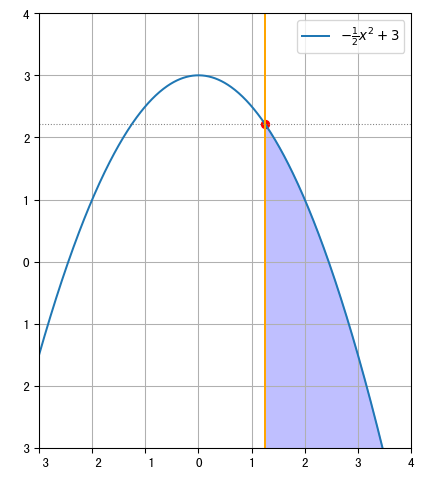

In [2]:
# plot the target problem
plot_example_1(plt)

In [3]:
# initialize variables
P = matrix(np.array([[0, 0], [0, 1]], dtype=np.float))
q = matrix(np.array([-3, 0], dtype=np.float))
G = matrix(np.array([[0, -1]], dtype=np.float))
h = matrix(np.array([-1.25], dtype=np.float))
A = matrix(np.array([[1, 0]], dtype=np.float))
b = matrix(np.array([1], dtype=np.float))

sol = solvers.qp(P, q, G, h, A, b)

# find the solution
print("x^star={:.2f}".format(sol["x"][1]))

x^star=1.25


## PartII: Hard-Margin SVM with QP
In this section, we formally start our adventure in SVM!
### 2.1 First, load in the toy data

In [4]:
# load in data
X, y = load_in_data()

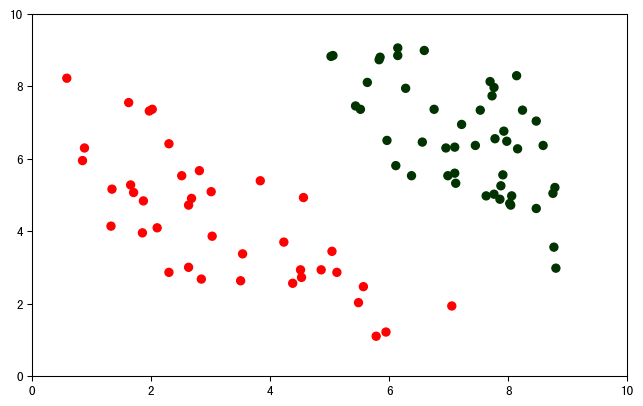

In [5]:
# visualize the data points
plot_Xy(X, y, plt)

### 2.2 Second, solve SVM by QP
Recall that the standard form of QP is:
$$
    \text{minimize }\frac{1}{2}x^TPx+q^Tx\\
    Gx \preceq h\\
    Ax=b
$$
The objective function of hard-margin SVM is:
$$
    \min_{w, b} \frac{1}{2} \textbf{w}^T \textbf{w}
$$
$$
    s.t: \,\, \forall i\in[N]: y_n (\textbf{w}^Tx_n+b) \geqslant 1
$$
Dumping each variable from SVM into the standard QP problem(check by yourself!).
$$
\textbf{P}=
 \left[
 \begin{matrix}
   0 & \textbf{0}_d^T \\
   \textbf{0}_d & \textbf{I}_d \\
  \end{matrix}
 \right]
,
\textbf{q}=\textbf{0}_{d+1}
,
\textbf{G}=
 \left[
 \begin{matrix}
   -y_1 & -y_1\textbf{x}_1^T \\
   -y_2 & -y_2\textbf{x}_2^T \\
   \vdots & \vdots \\
   -y_N & -y_N\textbf{x}_2^T \\
  \end{matrix}
 \right]
,
\textbf{h}=-\textbf{1}_N
$$

In [8]:
class SVM():

    def __init__(self):
        self.has_fitted = False
        # threshold for identifying that this vector is support vector
        self.sp_v_threshold = 1e-8
        # list for supoort vector indexes
        self.sp_v_i = []

    def fit(self, X, y):
        assert len(X) > 0, "Please input at least one sample"

        # specify the shape
        n = len(X)
        dim = len(X[0])

        # initialize variables
        self.P = matrix(np.identity(dim + 1, dtype=np.float))
        self.q = matrix(np.zeros((dim + 1,), dtype=np.float))
        self.G = matrix(np.zeros((n, dim + 1), dtype=np.float))
        self.h = -matrix(np.ones((n,), dtype=np.float))

        # dump the data into variables
        # P
        self.P[0, 0] = 0
        # G = [y_1, --y_1 x_1^T--; y_2, --y_2 x_2^T--, ..., y_n, --y_n x_n^T]
        for i in range(n):
            self.G[i, 0] = -y[i]
            self.G[i, 1:] = -X[i, :] * y[i]

        sol = solvers.qp(self.P,
                         self.q,
                         self.G,
                         self.h
                         )

        # find the solution
        self.w = np.zeros(dim,) # weight
        self.b = sol["x"][0] # bias
        for i in range(1, dim + 1):
            self.w[i - 1] = sol["x"][i]
        
        # find the indexes of support vectors
        for i in range(n):
            v = y[i] * (np.dot(self.w, X[i]) + self.b)
            if v < (1 + self.sp_v_threshold):
                self.sp_v_i.append(i)
        self.has_fitted = True
        return self.w, self.b

    def predict(self, X):
        """
        predict the results due to the result of trainning
        :param X:
        :return: y_hat: numpy.array[n, ], with +1 positve sample while -1 negative sample
        """
        assert self.has_fitted, "Model has not been trained"
        return np.sign(np.dot(self.w, X.T) + self.b)

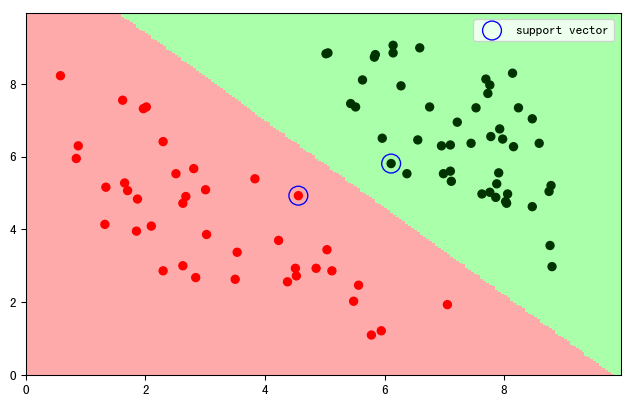

In [7]:
model = SVM()
model.fit(X, y)
plot_classifer(model, X, y, plt)

Yeh! You have conquered the problem of hard-margin SVM! For now, it is only on toy data. You can try the model by yourself on real scenerio.
## Acknowledgement
The formulation of hard-margin SVM in QP refers to Learning from Data e-Chapter 8.